# Controling the parameters of a distribution with a neural network

In this notebook we demonstrate how to use a neural network to control the parameters of a distribution on a one dimensional example. The result is a a different distribution for each input value $x$. Mathematically, we have a model for the conditional distribution 

$$
p(y|x)
$$.

This is also known under the name of distributional regression. In our case both $x$ and $y$ are one dimensional.


See also https://github.com/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_01.ipynb for a more detailed introduction.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


tfd = tfp.distributions

try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB, ' tensorflow_probability version: ', tfp.__version__)

Tensorflow version:  2.15.0  running in colab?:  False  tensorflow_probability version:  0.23.0


### Definition of a simple neural network controlling the parameters of a distribution

In [2]:
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale = 1e-3 + tf.math.softplus(params[:,1:2]))

inputs = Input(shape=(1,))
#---- here could be any other NN architecture ----
x = Dense(20, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
x = Dense(20, activation='tanh')(x)
params = Dense(2, activation='linear')(x) #<--- Important: two output nodes (first models mean, second models standard deviation)
dist = tfp.layers.DistributionLambda(my_dist)(params) #<--- Connect the NN to the distribution (here my_dist)

model = Model(inputs=inputs, outputs=dist)

Side note: In case you wonder, why we do not use relu activations in the hidden layers, the reason is that we want to have a smooth function for the parameters of the distribution and relu tend to produce non smooth functions. Go try it out yourself, and change the activation functions to relu.

### The model results in a distribution
The result of the model is a distribution $p(y|x)$

tf.Tensor([[0.5641135]], shape=(1, 1), dtype=float32) tf.Tensor([[0.49740183]], shape=(1, 1), dtype=float32)
(1, 1) (100,) (100,)


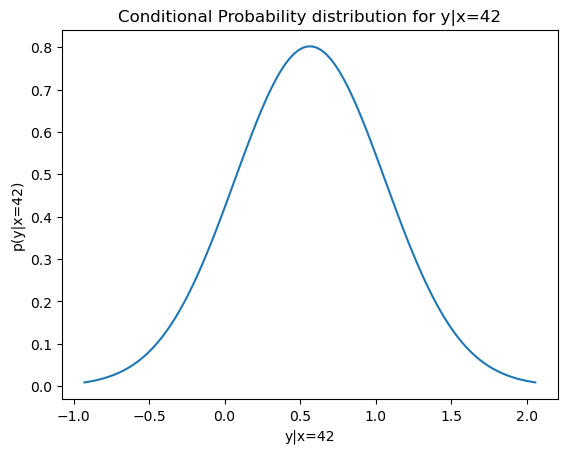

In [3]:
x = np.array([[42.0]]) #One x-values produces 1 distribution
res = model(x)
print(res.mean(), res.stddev())
ys = np.linspace(res.mean()-3*res.stddev(), res.mean()+3*res.stddev(), 100).flatten()
res.log_prob(ys).numpy().flatten()

print(x.shape, ys.shape, res.log_prob(ys).numpy().flatten().shape)
plt.plot(ys, np.exp(res.log_prob(ys).numpy().flatten()))
plt.xlabel('y|x=42')
plt.ylabel('p(y|x=42)')
plt.title('Conditional Probability distribution for y|x=42')
plt.show()

### Training
The training is done by maximizing the log-likelihood of the data given the model.

In [4]:
def NLL(y, distr): 
  return -distr.log_prob(y)

model.compile(Adam(), loss=NLL) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

Text(0.5, 1.0, 'Simulated data set (training data)')

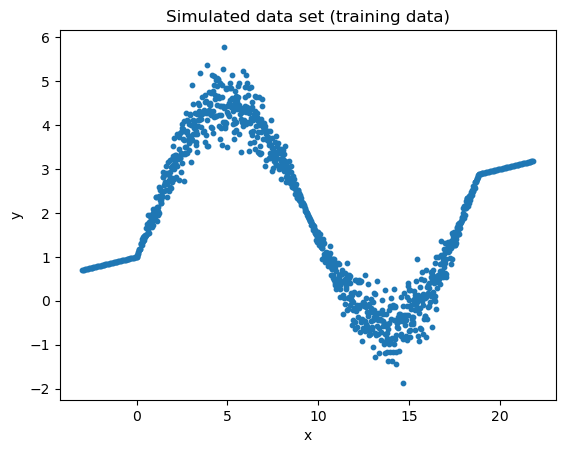

In [5]:
import numpy as np

def dgp(n):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x.reshape(-1,1),y.reshape(-1,1)

np.random.seed(42)
x_train, y_train = dgp(1000)

plt.scatter(x_train, y_train, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated data set (training data)')

In [6]:
# Checking if output of untrained model is reasonable for data
xs = np.linspace(-1, 6, 10)
model(xs).mean().numpy().flatten(), model(xs).stddev().numpy().flatten()

(array([-0.19325778, -0.04945055,  0.11838688,  0.23614758,  0.30608156,
         0.35346133,  0.38896725,  0.41645598,  0.43814808,  0.45568323],
       dtype=float32),
 array([0.79367244, 0.7187589 , 0.63757366, 0.5853265 , 0.55964607,
        0.54725856, 0.5406436 , 0.5362953 , 0.532634  , 0.5290503 ],
       dtype=float32))

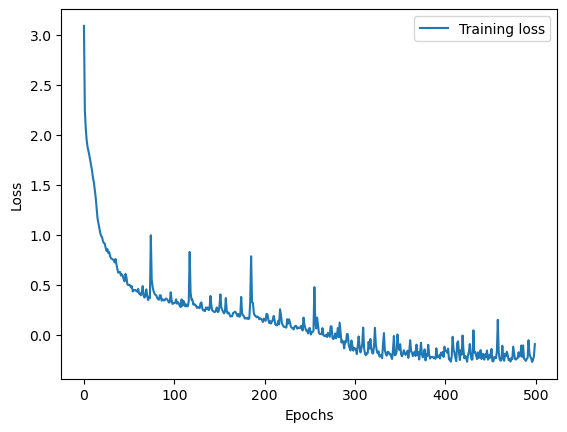

In [7]:
## Train the model
num_epochs = 500
hist = model.fit(x_train, y_train, epochs=num_epochs, verbose=False)

## Plot the loss
plt.plot(hist.history['loss'], label='Training loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Text(0.5, 1.0, 'train data')

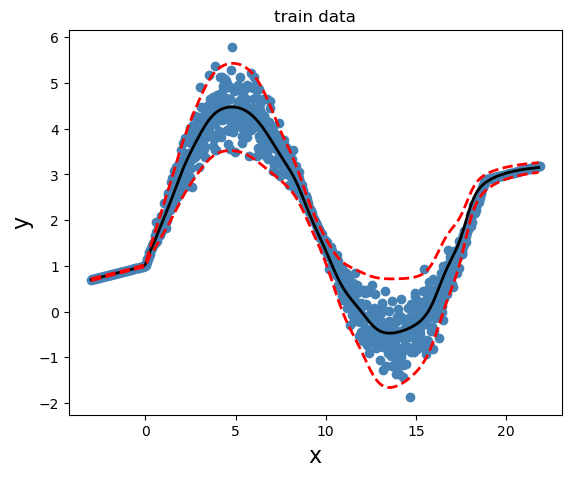

In [8]:
plt.figure(figsize=(14,5))

x_pred = np.arange(x_train.min(),x_train.max(),0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model(x_pred)
mu = preds.mean().numpy().flatten()
sigma = preds.stddev().numpy().flatten()
plt.plot(x_pred,mu,color="black",linewidth=2)
plt.plot(x_pred,mu+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,mu-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")

# Doing the same in pytorch

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td

print("PyTorch version: ", torch.__version__)

num_epochs = 500
class DistributionNetwork(nn.Module):
    def __init__(self):
        super(DistributionNetwork, self).__init__()
        # Define layers
        self.layer1 = nn.Linear(1, 20)
        self.layer2 = nn.Linear(20, 50)
        self.layer3 = nn.Linear(50, 20)
        # Output layer for mean and standard deviation
        self.mean_layer = nn.Linear(20, 1)
        self.std_layer = nn.Linear(20, 1)
    
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        mean = self.mean_layer(x)
        # Ensure standard deviation is positive
        std = torch.nn.functional.softplus(self.std_layer(x))
        return td.Normal(mean, std)

# Example usage
model_pt = DistributionNetwork()
p_y_x1 = model_pt(torch.tensor([1.0]))
print(p_y_x1.mean.detach().numpy(), p_y_x1.stddev.detach().numpy())

PyTorch version:  2.1.2
[0.19795173] [0.73215073]


In [10]:
# Custom Dataset
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and data loader
dataset = CustomDataset(x_train, y_train)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Epoch 1, Loss: 2.392296314239502
Epoch 51, Loss: 0.23711222410202026
Epoch 101, Loss: 0.6951823234558105
Epoch 151, Loss: 0.21722084283828735
Epoch 201, Loss: 0.008256010711193085
Epoch 251, Loss: 0.06865374743938446
Epoch 301, Loss: 0.12256795167922974
Epoch 351, Loss: -0.14242835342884064
Epoch 401, Loss: -0.07747786492109299
Epoch 451, Loss: 0.09276959300041199


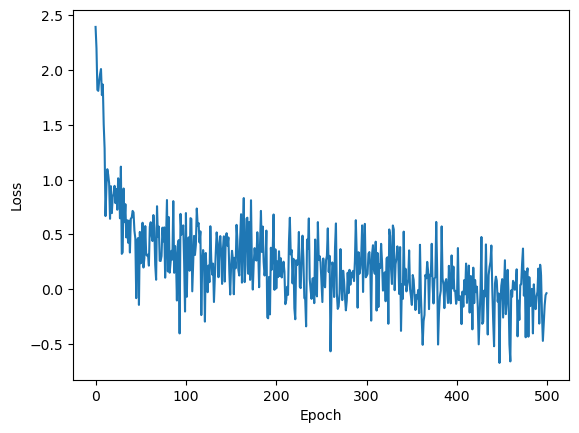

In [11]:
optimizer = optim.Adam(model_pt.parameters())

losses = []
for epoch in range(num_epochs):
    for inputs, targets in data_loader:
        # Forward pass: Model outputs a distribution
        distribution = model_pt(inputs)

        # Compute the NLL loss
        # Note: NLL loss is negative log likelihood
        loss = -distribution.log_prob(targets).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the loss for this epoch
    losses.append(loss.item())
    if epoch % int(num_epochs/10) == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Text(0, 0.5, 'y')

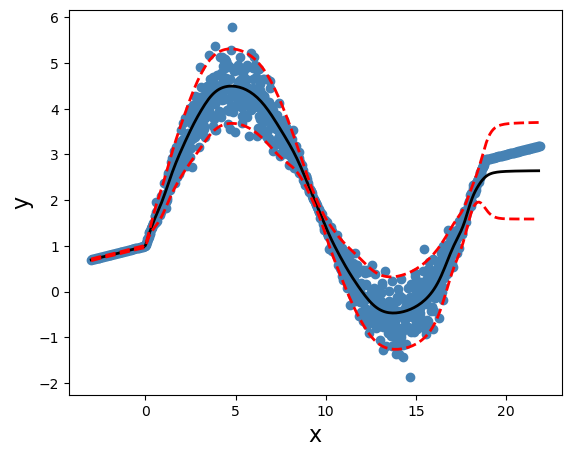

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.figure(figsize=(14, 5))

# Generating prediction inputs
x_pred = np.arange(x_train.min(), x_train.max(), 0.1).reshape(-1, 1)
x_pred_tensor = torch.from_numpy(x_pred).float()
preds = model_pt(x_pred_tensor)
mu = preds.mean[:,0].detach().numpy()
sigma = preds.stddev[:,0].detach().numpy()


# Plotting
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, color="steelblue")  # Observed data
plt.plot(x_pred.flatten(), mu, color="black", linewidth=2)  # Mean prediction
plt.plot(x_pred.flatten(), mu + 2 * sigma, color="red", linestyle="--", linewidth=2)  # Upper confidence bound
plt.plot(x_pred.flatten(), mu - 2 * sigma, color="red", linestyle="--", linewidth=2)  # Lower confidence bound
plt.xlabel("x", size=16)
plt.ylabel("y", size=16)